# DLBasics2023 最終課題
実行結果付き。
（探索フェーズ：完了。活用フェーズは途中までなので利用せず、別途実行した。）
### 作者： tfujiwara
### 日付： 2023-Aug-02

## 課題
第11回「変分オートエンコーダ（VAE）を用いてFasionMNISTの画像を生成してみましょう」<br>
を発展させ、学習率探索プログラムを開発する

### 目標

課題の目標値は「NLL（負の対数尤度） 235」であったが、これにこだわらず、
自動探索により、良い検証結果の出る学習率が得られることとする。
以下の、オリジナル課題ルールは、あえて変更せず、**学習率とエポック数以外の条件を固定した中で、最良の検証結果を出す。**

### オリジナル課題ルール

- 訓練データは`x_train`，テストデータは`x_test`で与えられます．
- 下のセルで指定されている`x_train`以外の学習データは使わないでください．

### 評価方法

- 評価は生成画像の検証データに対するNLL（負の対数尤度）とした。<br>（オリジナル課題は、テストデータに対するNLL）

\begin{equation}
-\sum_{i=1}^Dx_i\log\hat{x_i}+(1-x_i)\log(1-\hat{x_i})
\end{equation}

### ドライブのマウント

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### データの読み込み（このセルはフォルダ名のみ修正）

In [ ]:
import numpy as np
import pandas as pd
import torch

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

# 学習データ
x_train = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_train.npy')
# テストデータ
x_test = np.load('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/data/x_test.npy')


class dataset(torch.utils.data.Dataset):
    def __init__(self, x_test):
        self.x_test = x_test.reshape(-1, 784).astype('float32') / 255

    def __len__(self):
        return self.x_test.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.x_test[idx], dtype=torch.float)

trainval_data = dataset(x_train)
test_data = dataset(x_test)

### VAEの実装


In [ ]:
batch_size = 32

val_size = 10000
train_size = len(trainval_data) - val_size

train_data, val_data = torch.utils.data.random_split(trainval_data, [train_size, val_size])

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_test = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False
)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from typing import Tuple

device = "cpu"

# torch.log(0)によるnanを防ぐ
def torch_log(x):
    return torch.log(torch.clamp(x, min=1e-10))

# VAEモデルの実装
class VAE(nn.Module):
    # WRITE ME
    def __init__(self, z_dim: int) -> None:
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean
    def _sample_z64(self, mean: torch.Tensor, std: torch.Tensor, L: int = 64) -> torch.Tensor:
        if self.training:
            # 再パラメータ化トリック．この乱数は計算グラフで勾配の通り道に無い．
            epsilon = torch.randn(L, *mean.shape).to(device)
            return mean + std * epsilon
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean, std = self._encoder(x)

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=-1))

        return KL, -reconstruction

# 自分の関数を追加

テスト
n_lr_list=4, lr_list=[0.003, 0.002, 0.001, 0.0]
n_rs_list=4, rs_list=[2, 2, 4, 4]
n_new_lr_list=3, new_lr_list=[0.003, 0.001, 0.0]


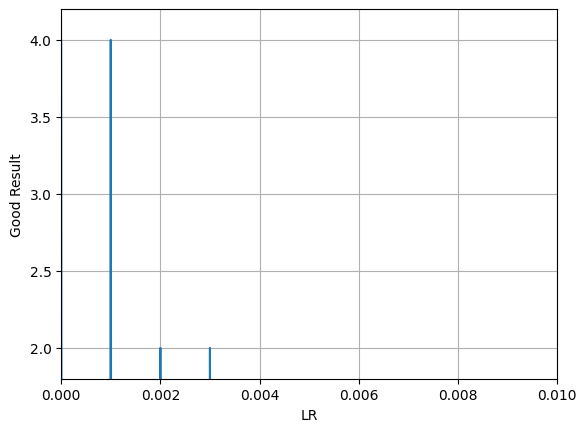

n_lr_list=30, lr_list=[0.0034, 0.0033, 0.0032, 0.0031, 0.003, 0.0029, 0.0028, 0.0027, 0.0026, 0.0025, 0.0024, 0.0023, 0.0022, 0.0021, 0.002, 0.0014, 0.0013, 0.0012, 0.0011, 0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001, 0.0]
n_rs_list=30, rs_list=[2, 2, 4, 4, 2, 2, 0, 1, 3, 0, 0, 1, 1, 2, 0, 3, 1, 0, 3, 1, 2, 0, 1, 1, 1, 2, 2, 3, 1, 3]
n_new_lr_list=3, new_lr_list=[0.0032, 0.0031, 0.0026]


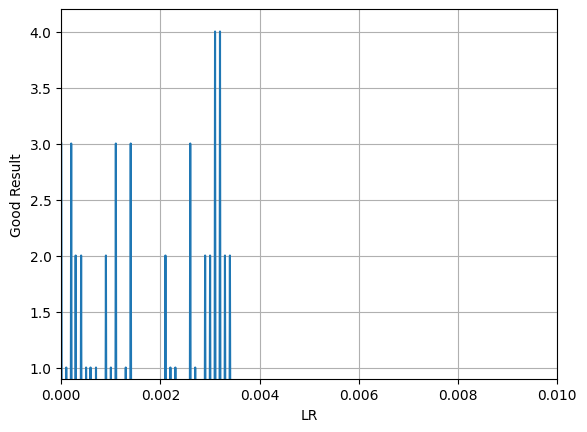

n_lr_list=40, lr_list=[0.00324, 0.00323, 0.00322, 0.00321, 0.0032, 0.00319, 0.00318, 0.00317, 0.00316, 0.00315, 0.00314, 0.00313, 0.00312, 0.00311, 0.0031, 0.00309, 0.00308, 0.00307, 0.00306, 0.00305, 0.00304, 0.00303, 0.00302, 0.00301, 0.003, 0.00264, 0.00263, 0.00262, 0.00261, 0.0026, 0.00259, 0.00258, 0.00257, 0.00256, 0.00255, 0.00254, 0.00253, 0.00252, 0.00251, 0.0025]
n_rs_list=40, rs_list=[2, 0, 4, 4, 0, 0, 1, 0, 3, 3, 0, 0, 3, 0, 3, 3, 2, 2, 1, 0, 0, 1, 2, 0, 2, 2, 1, 1, 1, 1, 2, 3, 1, 1, 2, 1, 1, 2, 1, 1]
n_new_lr_list=3, new_lr_list=[0.00322, 0.00321, 0.00316]


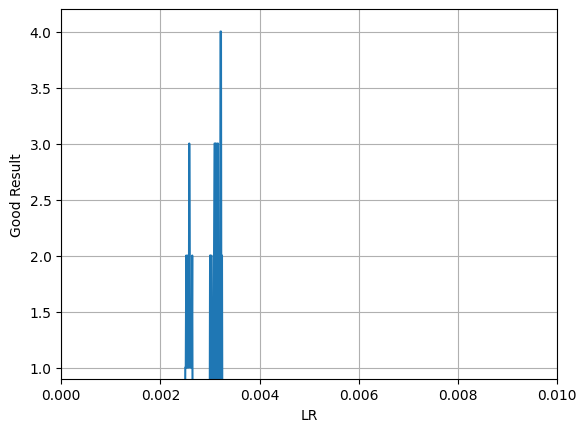

実行した epoch数 = 74


<Figure size 640x480 with 0 Axes>

In [ ]:
from IPython.core.events import pre_execute
import torch
device = "cpu"
import datetime
import pytz
import math
timezone = 'Europe/Budapest'

def datetime_now():
    new_timezone = pytz.timezone(timezone)
    return datetime.datetime.now().astimezone(new_timezone)

class LogPrint:
    ### 最大値だけを記録。
    def __init__(self, filename, mystr):
        self.filename = filename
        if ( mystr != "" ):
            self.message_time(mystr)
    def message(self, mystr):
        xprint.message(mystr)
        try:
            with open(self.filename, "a") as f:
                f.write("{}\n".format(mystr))
        except FileNotFoundError:
            print("* "+mystr)
            return
        print("  "+mystr)
    def message_time(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))

class xPrint:
    ### 画面と同じものを記録する。
    def __init__(self, filename, mystr):
        self.filename = filename
        if ( mystr != "" ):
            self.message_time(mystr)
    def __call__(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))
    def message(self, mystr):
        try:
            with open(self.filename, "a") as f:
                f.write("{}\n".format(mystr))
        except FileNotFoundError:
            print("* "+mystr)
            return
        print("  "+mystr)
    def message_time(self, mystr):
        self.message("{} {}".format(datetime_now().strftime("%Y/%m/%d %H:%M:%S"), mystr))

xprint = xPrint('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/xprint{}.txt'.format(datetime_now().strftime("%Y%m%d")), "")
xlogprint = LogPrint('drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/xlogprint.txt', "")

import csv
def predict_testdata(valid_lower_bound, epoch, lr, z_dim, batch_size):
    sample_x = []
    answer = []
    model.eval()
    for x in dataloader_test:
        x = x.to(device)
        y, _ = model(x)
        y = y.tolist()
        sample_x.extend(y)

    with open( f'drive/MyDrive/Colab Notebooks/DLBasics2023_colab/FinalProj/submission_pred_{valid_lower_bound:8.2f}_{epoch:05d}_lr{lr:.6f}_dim{z_dim:04d}_bat{batch_size:04d}.csv', 'w') as file:
        writer = csv.writer(file, lineterminator='\n')
        writer.writerows(sample_x)
    file.close()

import random                                       # テスト用
class GenerateLr():
    from enum import Enum                           # Enumをクラスの中に定義する
    class Direction(Enum):
        GOOD_ON_HIGHER = 1                          # 大きい数値を良い結果と規定する。
        GOOD_ON_LOWER = -1                          # 小さい数値を良い結果と規定する。
    def __init__(self):
        self.pre_block_gy = 0
        self.ave_block_gy = 0
        self.started = False

    def starting_exp(self, lr_start_exp:int=3, n_lr:int=5):
        """---------------------------------------------------------------------------------------------------------------------------
        初めの学習率リストを生成する。
        [arguments]
            lr_start_exp:   生成する学習率リストの指数 3であれば、1.e-3 から、9.e-3 のリストを生成する。
            n_lr:           生成する学習率の数。
        [return]
            lr_list:        生成された学習率のリスト。例： starting_exp(3)　であれば、[0.001 0.002 0.003 0.004 0.005]
        """
        lr_list = []
        self.lr_start_exp = lr_start_exp
        for i in range(0, n_lr):
            lr = (n_lr-i-1) / pow(10, lr_start_exp)         # 0.e-3 から 9.e-3 を作り上げる
            lr_list.append(lr)
        return lr_list

    def pick_good_lr(self, lr_list, rs_list, direction:Direction=Direction.GOOD_ON_HIGHER, n_next_lr:int=5):
        """----------------------------------------------------------------------------------------------------------------------------
        良い学習結果を出した学習率だけを取り出す。
        [arguments]
            lr_list:    学習を行った学習率のリスト
            rs_list:    それぞれの学習率に対応した、学習結果。Direction=GOOD_ON_HIGHERであれば、rs_list内の大きい数字が良い結果を表す。
            direction:  rs_listリスト内の数値の意味。GOOD_ON_HIGHER(大きい数字=良い) あるいは GOOD_ON_LOWER(小さい数字=良い)
            n_next_lr:  生成する lr_list のリストに含める学習率の数。
        [return]
            lr_list:    生成された、学習率のリスト
        [example]
            lr_list = [0.01 0.02 0.03 0.04]                                                 # 実施した学習率のリスト
            rs_list = [0 4 1 0]                                                             # 実施した学習結果。Accuracy などの数値。
            new_lr_list = pick(lr_list, rs_list, GenerateLr.Direction.GOOD_ON_HIGHER, 2)    # 結果が良かった学習率を 2つだけ抽出する。
            print(f"{new_lr_list})                                                          # 抽出した new_lr_list を表示する
            [0.02 0.03]                                                                     # 結果が表示される。
        """
        ix = [i for i in range(0, len(lr_list))]                                            # インデックスソートのインデックス配列を初期化
        # インデックスソート
        for i in range(0, len(lr_list)):
            for j in range(i, len(lr_list)):
                dir = 1 if direction == self.Direction.GOOD_ON_HIGHER else -1
                if (rs_list[ ix[i] ] * dir) < (rs_list[ ix[j] ] * dir):
                    tmp = ix[i]
                    ix[i] = ix[j]
                    ix[j] = tmp
        #print(f"ix: {ix}")
        new_lr_list = []
        if 0 < len(ix):
            for i in range(0, n_next_lr):
                if rs_list[ix[i]] == 0:
                    #このlrで良い値が出なかった。このlrに価値がないため、ここからlrを掘り下げる必要がない=終了。
                    break
                new_lr_list.append(lr_list[ix[i]])
        return new_lr_list

    def dig(self, in_lr_list, n_digits:int, n_lr:int=10):
        """----------------------------------------------------------------------------------------------
        1つの学習率から、その周辺の学習率をリストとして生成する。
        [arguments]
            in_lr_list: 次の学習率リストを生成する、元となる学習率のリスト
            n_digits:   生成する学習率の有効桁数　0.000300 から0.000310 を作り出す場合は、2とする。
            n_lr:       それぞれの学習率から生成する学習率リストの要素数。lr_listに含まれる要素数は、len(in_lr_list)*n_lrとなる
        [return]
            lr_list:    生成された、学習率のリスト
        [example]
            lr_list = dig(0.000300, 2, 7)
            print(f"{lr_list}")
            [0.000270 0.000280 0.000290 0.000300 0.000310 0.000320 0.000330]
            #-0.3     -0.2     -0.1     base_lr  +0.1     +0.2     +0.3

            lr_list = dig([0.000300], 3, 8)
            print(f"{lr_list}")
            [0.000296 0.000297 0.000298 0.000299 0.000300 0.000301 0.000302 0.000303]
            #-0.4     -0.3     -0.2     -0.1     base_lr  +0.1     +0.2     +0.3
        """
        lr_list = []
        # in_lr_listのそれぞれの要素値を、base_lr とし、base_lrの付近の学習率を作る。
        for base_lr in in_lr_list:
            delta =  1 / pow(10, (n_digits + self.lr_start_exp))
            # 前半のリスト要素を作る。base_lrより大きい数値。
            n = min(4, int(n_lr/2+.5)-1)
            for i in range(0, n):
                new_lr = base_lr + ((n)-i) * delta
                new_lr = float( format(new_lr, f".{n_digits}e") )
                # lr_listにnew_lrがなければ、追加する
                lr_list_tmp = lr_list
                if new_lr not in lr_list_tmp:
                    lr_list.append(new_lr)
                    #print(f"base_lr={base_lr}, digits={n_digits}, delta={delta:.8f} new_lr={new_lr:.8f}, lr_list={lr_list}")
            # 後半のリスト要素を作る。後半とは、base_lr および、base_lrより小さい数値。
            for i in range(0, (n_lr - n) ):
                new_lr = base_lr - (i) * delta
                new_lr = float( format(new_lr, f".{i+1}e") )
                if 0 <= new_lr:
                    # lr_listにnew_lrがなければ、追加する
                    lr_list_tmp = lr_list
                    if new_lr not in lr_list_tmp:
                        lr_list.append(new_lr)
            #print(f"base_lr={base_lr}, digits={n_digits}, lr_list={lr_list}")
        return lr_list
    def is_worth_to_continue(self, total_n_epochs, one_block):
        global gy
        if total_n_epochs % one_block == 0:
            self.prev_block_gy = self.ave_block_gy
            self.ave_block_gy = sum( gy[max(0, total_n_epochs-one_block): total_n_epochs] ) / one_block
            #print(f"started={self.started}, total_n_epochs={total_n_epochs}, prev_block_gy={self.prev_block_gy}, ave_block_gy={self.ave_block_gy}")
            if self.started == True:
                if (self.prev_block_gy != 0) and (self.prev_block_gy < self.ave_block_gy):
                    # 過学習か。
                    return False
            self.started = True
        return True

print(f"テスト")
import matplotlib.pyplot as plt
plt.clf()

total_n_epochs = 0
generate_lr = GenerateLr()
lr_list = generate_lr.starting_exp(3, 4)                                       # generate exp3 = 0.000x 有効桁数=1の学習率を20個作る。
for i in range(0, 3):
    print(f"n_lr_list={len(lr_list)}, lr_list={lr_list}")
    total_n_epochs += len(lr_list)
    lr = [0 for i in range(0, 1000)]                    # 0で初期化
    rs_list = []
    for ii in range(0, len(lr_list)):
        rs = random.randint(0, 3)
        if ii == 2 or ii == 3:
            rs = 4
        rs_list.append( rs )                            #テスト用。それぞれのlr学習率に対する、学習結果（大きいほど良い）を設定する。
        lr[int(lr_list[ii]*100000)] += rs               #テスト用。学習結果を加算する。
    print(f"n_rs_list={len(rs_list)}, rs_list={rs_list}")

    # 実行した学習率の結果から、厳選されたlr_listを得る。 厳選数は元の半分の数とする。
    new_lr_list = generate_lr.pick_good_lr(lr_list, rs_list, generate_lr.Direction.GOOD_ON_HIGHER, 3)
    new_lr_list.sort(reverse=True)                      # 学習結果が良かった順→結果に関係なく、学習率の降順にソートする。
    print(f"n_new_lr_list={len(new_lr_list)}, new_lr_list={new_lr_list}")
    plt.plot([i/100000 for i in range(0, 1000)], lr)
    plt.xlim(0, 0.01)
    plt.ylim(min(num for num in lr if num != 0)*.9)
    plt.xlabel("LR")
    plt.ylabel("Good Result")
    plt.grid(True)
    plt.show()
    plt.clf()
    # 厳選されたlr_listのそれぞれに対して、有効桁数を増やしたの学習率を複数作る。
    lr_list = generate_lr.dig(new_lr_list, i+1, 15)

print(f"実行した epoch数 = {total_n_epochs}")


  2023/07/29 07:37:36 プログラム開始
  2023/07/29 07:37:36 [探索フェーズ]
  2023/07/29 07:37:36 n_lr_list=4, lr_list=[0.003, 0.002, 0.001, 0.0]
  2023/07/29 07:37:53 EPOCH:00001, Train_Lower_Bound:263.20, (8.99, 254.21), Valid_Lower_Bound:249.25 lr:0.00300000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:38:01 EPOCH:00002, Train_Lower_Bound:250.63, (9.20, 241.43), Valid_Lower_Bound:247.31 lr:0.00300000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:38:12 EPOCH:00003, Train_Lower_Bound:249.01, (9.33, 239.67), Valid_Lower_Bound:246.36 lr:0.00300000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:38:25 EPOCH:00004, Train_Lower_Bound:248.21, (9.41, 238.80), Valid_Lower_Bound:246.27 lr:0.00300000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:38:33 EPOCH:00005, Train_Lower_Bound:247.55, (9.48, 238.07), Valid_Lower_Bound:244.58 lr:0.00300000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:38:42 EPOCH:00006, Train_Lower_Bound:247.13, (9.52, 237.62), Valid_Lower_Bound:244.30 lr:0.00300000 z_dim:10 batch_size:32 

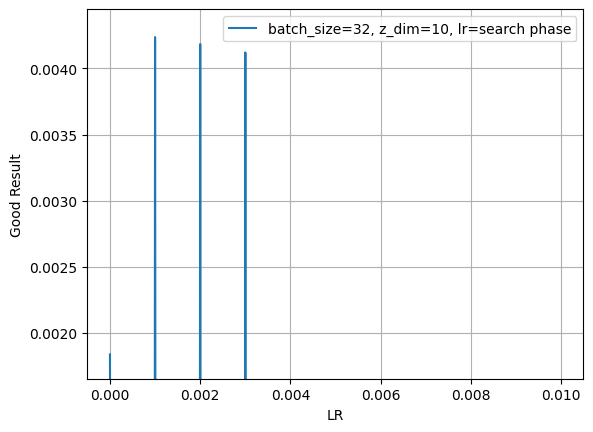

  2023/07/29 07:57:57 n_lr_list=25, lr_list=[0.0024, 0.0023, 0.0022, 0.0021, 0.002, 0.0019, 0.0018, 0.0017, 0.0016, 0.0015, 0.0014, 0.0013, 0.0012, 0.0011, 0.001, 0.0009, 0.0008, 0.0007, 0.0006, 0.0005, 0.0004, 0.0003, 0.0002, 0.0001, 0.0]
  2023/07/29 07:58:06 EPOCH:00152, Train_Lower_Bound:265.52, (9.49, 256.03), Valid_Lower_Bound:248.98 lr:0.00240000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:58:14 EPOCH:00153, Train_Lower_Bound:249.23, (10.29, 238.94), Valid_Lower_Bound:245.25 lr:0.00240000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:58:21 EPOCH:00154, Train_Lower_Bound:247.04, (10.50, 236.54), Valid_Lower_Bound:244.04 lr:0.00240000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:58:30 EPOCH:00155, Train_Lower_Bound:245.88, (10.59, 235.28), Valid_Lower_Bound:242.54 lr:0.00240000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 07:58:37 EPOCH:00156, Train_Lower_Bound:245.24, (10.65, 234.59), Valid_Lower_Bound:242.55 lr:0.00240000 z_dim:10 batch_size:32 
  2023/07/29 07:58:45 EPOCH:0015

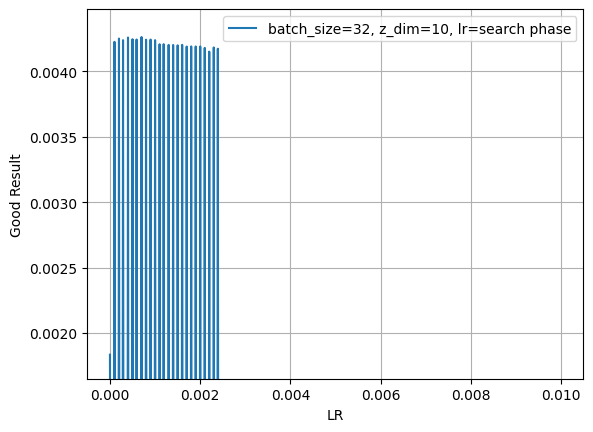

  2023/07/29 10:33:03 n_lr_list=30, lr_list=[0.00074, 0.00073, 0.00072, 0.00071, 0.0007, 0.00069, 0.00068, 0.00067, 0.00066, 0.00065, 0.00064, 0.00063, 0.00062, 0.00061, 0.0006, 0.00044, 0.00043, 0.00042, 0.00041, 0.0004, 0.00039, 0.00038, 0.00037, 0.00036, 0.00035, 0.00034, 0.00033, 0.00032, 0.00031, 0.0003]
  2023/07/29 10:33:11 EPOCH:01353, Train_Lower_Bound:273.25, (9.41, 263.84), Valid_Lower_Bound:250.60 lr:0.00074000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 10:33:18 EPOCH:01354, Train_Lower_Bound:250.17, (10.72, 239.45), Valid_Lower_Bound:245.26 lr:0.00074000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 10:33:26 EPOCH:01355, Train_Lower_Bound:246.62, (11.09, 235.53), Valid_Lower_Bound:242.55 lr:0.00074000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 10:33:33 EPOCH:01356, Train_Lower_Bound:244.83, (11.29, 233.54), Valid_Lower_Bound:241.71 lr:0.00074000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 10:33:41 EPOCH:01357, Train_Lower_Bound:243.63, (11.41, 232.22), Valid_Lower_Bound:240.50

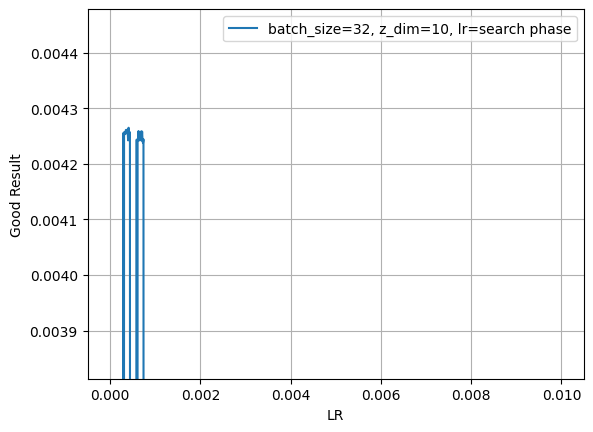

  2023/07/29 13:42:44 [活用フェーズ]
  2023/07/29 13:42:44 n_lr_list=2, lr_list=[0.00041, 0.00038]
  2023/07/29 13:42:51 EPOCH:02853, Train_Lower_Bound:282.54, (9.64, 272.90), Valid_Lower_Bound:255.06 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:42:59 EPOCH:02854, Train_Lower_Bound:253.34, (10.80, 242.54), Valid_Lower_Bound:246.88 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:43:06 EPOCH:02855, Train_Lower_Bound:248.73, (11.27, 237.46), Valid_Lower_Bound:244.08 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:43:14 EPOCH:02856, Train_Lower_Bound:246.35, (11.70, 234.66), Valid_Lower_Bound:242.85 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:43:22 EPOCH:02857, Train_Lower_Bound:244.78, (11.95, 232.84), Valid_Lower_Bound:240.83 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:43:29 EPOCH:02858, Train_Lower_Bound:243.69, (12.11, 231.57), Valid_Lower_Bound:240.37 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:43:37 EPOC

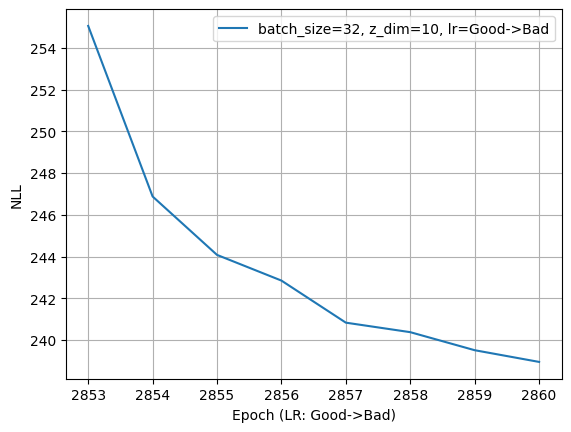

  2023/07/29 13:43:52 EPOCH:02861, Train_Lower_Bound:241.70, (12.39, 229.31), Valid_Lower_Bound:238.66 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:44:00 EPOCH:02862, Train_Lower_Bound:241.30, (12.47, 228.83), Valid_Lower_Bound:238.33 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:44:07 EPOCH:02863, Train_Lower_Bound:240.96, (12.53, 228.44), Valid_Lower_Bound:238.12 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:44:15 EPOCH:02864, Train_Lower_Bound:240.61, (12.56, 228.05), Valid_Lower_Bound:237.32 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:44:22 EPOCH:02865, Train_Lower_Bound:240.39, (12.61, 227.79), Valid_Lower_Bound:237.64 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:44:30 EPOCH:02866, Train_Lower_Bound:240.12, (12.63, 227.49), Valid_Lower_Bound:237.11 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:44:38 EPOCH:02867, Train_Lower_Bound:239.93, (12.67, 227.26), Valid_Lower_Bound:236.79 lr:0.00041000 z_dim:1

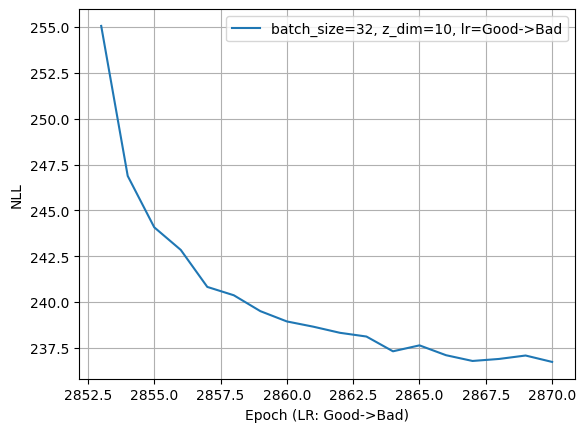

  2023/07/29 13:45:07 EPOCH:02871, Train_Lower_Bound:239.26, (12.74, 226.52), Valid_Lower_Bound:236.51 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:45:15 EPOCH:02872, Train_Lower_Bound:239.13, (12.76, 226.37), Valid_Lower_Bound:236.48 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:45:22 EPOCH:02873, Train_Lower_Bound:239.01, (12.78, 226.24), Valid_Lower_Bound:236.16 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:45:30 EPOCH:02874, Train_Lower_Bound:238.90, (12.76, 226.13), Valid_Lower_Bound:235.90 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:45:37 EPOCH:02875, Train_Lower_Bound:238.80, (12.79, 226.01), Valid_Lower_Bound:235.79 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:45:45 EPOCH:02876, Train_Lower_Bound:238.70, (12.81, 225.88), Valid_Lower_Bound:236.13 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:45:53 EPOCH:02877, Train_Lower_Bound:238.62, (12.82, 225.79), Valid_Lower_Bound:236.30 lr:0.00041000 z_dim:1

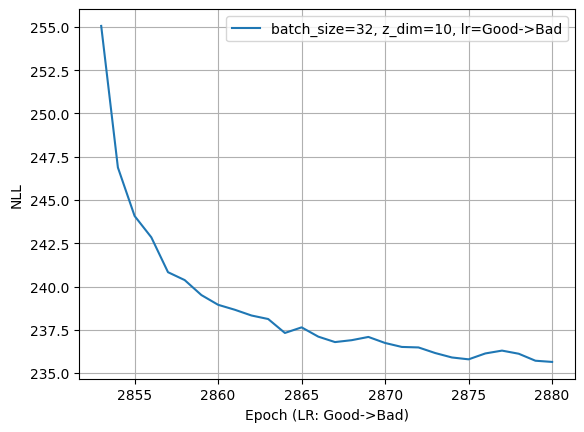

  2023/07/29 13:46:22 EPOCH:02881, Train_Lower_Bound:238.30, (12.86, 225.45), Valid_Lower_Bound:235.70 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:46:30 EPOCH:02882, Train_Lower_Bound:238.22, (12.85, 225.37), Valid_Lower_Bound:235.80 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:46:37 EPOCH:02883, Train_Lower_Bound:238.19, (12.89, 225.30), Valid_Lower_Bound:235.50 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:46:45 EPOCH:02884, Train_Lower_Bound:238.09, (12.88, 225.21), Valid_Lower_Bound:235.38 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:46:52 EPOCH:02885, Train_Lower_Bound:238.05, (12.88, 225.16), Valid_Lower_Bound:235.58 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:47:00 EPOCH:02886, Train_Lower_Bound:238.00, (12.89, 225.11), Valid_Lower_Bound:235.32 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:47:07 EPOCH:02887, Train_Lower_Bound:237.94, (12.90, 225.05), Valid_Lower_Bound:235.46 lr:0.00041000 z_dim:10 batch_size

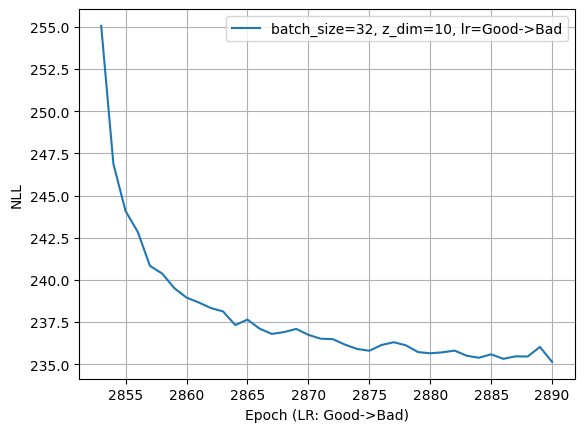

  2023/07/29 13:47:37 EPOCH:02891, Train_Lower_Bound:237.75, (12.92, 224.83), Valid_Lower_Bound:235.41 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:47:45 EPOCH:02892, Train_Lower_Bound:237.69, (12.92, 224.77), Valid_Lower_Bound:235.48 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:47:52 EPOCH:02893, Train_Lower_Bound:237.67, (12.92, 224.75), Valid_Lower_Bound:234.89 lr:0.00041000 z_dim:10 batch_size:32 最小値更新。
  2023/07/29 13:48:00 EPOCH:02894, Train_Lower_Bound:237.62, (12.94, 224.67), Valid_Lower_Bound:235.06 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:48:07 EPOCH:02895, Train_Lower_Bound:237.57, (12.94, 224.63), Valid_Lower_Bound:235.16 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:48:15 EPOCH:02896, Train_Lower_Bound:237.55, (12.94, 224.61), Valid_Lower_Bound:235.24 lr:0.00041000 z_dim:10 batch_size:32 
  2023/07/29 13:48:22 EPOCH:02897, Train_Lower_Bound:237.52, (12.95, 224.57), Valid_Lower_Bound:235.22 lr:0.00041000 z_dim:10 batch_size:32 
  2023/

In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
z_dim = 10
assert z_dim >= 2
#model = VAE(z_dim).to(device)
import matplotlib.pyplot as plt

def train_and_eval_by_lr(run_pass, new_lr, z_dim, model, trained_model_params, optimizer, n_epochs):
    global total_n_epochs
    global min_NLL
    global lr
    global epoch_list
    global gx                                                                   # グラフ表示用
    global gy                                                                   # グラフ表示用

    fail_counter = 0
    if run_pass == 1:
        min_NLL = 9999                                                          # n_epochs の中での最小値を保存する
    ave50_valid_lower_bound = 9999
    for epoch in range(n_epochs):
        total_n_epochs += 1                                                     # 表示用
        msg = ""
        br = False                                                              # breake = False

        losses = []
        KL_losses = []
        reconstruction_losses = []
        model.train()
        for x in dataloader_train:
            # WRITE ME
            x = x.to(device)
            model.zero_grad()
            # KL_loss, reconstruction_lossの各項の計算
            KL_loss, reconstruction_loss = model.loss(x)
            # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
            loss = KL_loss + reconstruction_loss
            loss.backward()
            optimizer.step()

            losses.append(loss.cpu().detach().numpy())
            KL_losses.append(KL_loss.cpu().detach().numpy())
            reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())
        losses_val = []
        model.eval()
        for x in dataloader_valid:
            # WRITE ME
            x = x.to(device)
            KL_loss, reconstruction_loss = model.loss(x)
            loss = KL_loss + reconstruction_loss
            losses_val.append(loss.cpu().detach().numpy())
        valid_lower_bound = np.average(losses_val)
        if valid_lower_bound < min_NLL:
            min_NLL = valid_lower_bound
            msg += "最小値更新。"
            fail_counter = 0
            """
            モデルを復元する件。とりあえずコメントとする。
            # 学習モデルを保存する。
            msg += モデル保存。
            trained_model_params = model.state_dict()
            """
            if valid_lower_bound < 234:
                predict_testdata(valid_lower_bound, epoch, new_lr, z_dim, batch_size)
        else:
            fail_counter += 1
            """
            # 最小値を更新できなかった - モデルを復元してつぎの学習率へ。
            msg += "モデル復元。つぎの学習率へ"
            model.load_state_dict(trained_model_params)
            """
        # 学習評価に対するメッセージを表示する。
        gx.append(total_n_epochs)
        gy.append(valid_lower_bound)
        if generate_lr.is_worth_to_continue(total_n_epochs, 50) == False and 50 <= fail_counter :
            # 過学習。もうだめ。
            msg += "過学習か。つぎの学習率へ。"
            br = True
        xprint.message_time( 'EPOCH:%05d, Train_Lower_Bound:%.2lf, (%.2lf, %.2lf), Valid_Lower_Bound:%.2lf lr:%.8f z_dim:%d batch_size:%d %s' %
            (total_n_epochs, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), valid_lower_bound, new_lr, z_dim, batch_size, msg))
        if run_pass == 2:
            if total_n_epochs % 10 == 0:
                plt.clf()
                plt.plot(gx, gy, label=f'batch_size={batch_size}, z_dim={z_dim}, lr=Good->Bad')
                plt.xlabel("Epoch (LR: Good->Bad)")                             # グラフ表示用
                plt.ylabel("NLL")                                               # グラフ表示用
                plt.grid(True)
                plt.legend()
                plt.show()
        if (new_lr == 0) or (br == True):
            break
    lr[int(new_lr*100000)] = 1/min_NLL                                          # グラフ表示用（最小値で考える場合）
    return min_NLL                                                              # 良い学習率であったかを示す値（Accuracyなど）を返す


def run_epoch(run_pass, lr_list, digits_start, digits_end, dup_count):
    """
    パラメータによって、つぎのどちらかが行われる。
    １．良い学習率のリストを生成する。
    ２．得られた良い学習率リストに基づき、連続実行する。
    [arguments]
    run_pass = 1 のとき（良い学習率リストを生成すとき）
        lr_list:        学習率リストの初期値
        digits_start:   学習率リストを作るループの初期値 通常 0
        digits_end:     学習率リストを作るループの初期値 通常 3
        dup_count:      同じ学習率で連続実行させる回数。
    run_pass = 2 のとき（実際の学習・評価を行うとき）
        lr_list:        学習率リスト
        digits_start:   学習率リストを作るループの初期値 通常 0
        digits_end:     学習率リストを作るループの初期値 通常 3
        dup_count:      同じ学習率で連続実行させる回数。
    [return]
        new_lr_list:    候補となる学習率に対して、有効桁数を増やした学習率リスト
                        - run_pass = 1 のとき、次回の学習率リストとして利用する。
                        - run_pass = 2 のときは、利用されない。
    """
    # パスごとに、変数を初期化する
    global lr
    global min_NLL

    # 求めた学習率リストを使って、良い結果を出すとき
    if run_pass == 2:
        # ここで、model の初期化を行う
        model = VAE(z_dim).to(device)
        trained_model_params = model.state_dict()
    for dig_id in range(digits_start, digits_end):
        xprint.message_time(f"n_lr_list={len(lr_list)}, lr_list={lr_list}")
        min_NLL = 9999                                                          # 最低のNLLを初期化。
        rs_list = []                                                            # rs_list: 検証結果を保存するリスト
        lr = [0 for i in range(0, 1000)]                                        # グラフ表示用。0で初期化
        for new_lr in lr_list:
            # 良い学習率を探す場合は、毎回リセットした状態からスタートする。積算するときは、この行を削除する。
            if run_pass == 1:
                # 毎回、ここでモデルの初期化を行う
                model = VAE(z_dim).to(device)
                trained_model_params = model.state_dict()
            optimizer = optim.Adam(model.parameters(), lr=new_lr)
            ## 途中から再開する場合
            ## 変数が同じになっていることが重要。
            ## total_n_epochs, lr, min_NLL, lr_list, run_pass, digits, dup_count,
            ## model, trained_model_params, dig_id, rs_list, new_lr,
            ## z_dim, dup_count : ファイルから取り出す。
            ## new_lr:  ファイルから取り出し、その値になるまで、forループを空回しする。
            # 学習と検証を行う
            min_valid_lower_bound =  train_and_eval_by_lr(run_pass, new_lr, z_dim, model,
                                                          trained_model_params,
                                                          optimizer, dup_count) # new_lrを使って、学習と評価を行う。dup_count回実行。
            rs_list.append( min_valid_lower_bound )                             # 良い学習率であったかを示す値（Accuracyなど）を保存する。
        #xprint.message_time(f"n_rs_list={len(rs_list)}, rs_list={rs_list}")

        # 実行した学習率の結果から、厳選されたlr_listを得る。 厳選数は元の半分の数とする。
        new_lr_list = generate_lr.pick_good_lr(lr_list,
                                               rs_list,
                                               generate_lr.Direction.GOOD_ON_LOWER,
                                               2)
        new_lr_list.sort(reverse=True)                                         # 学習結果が良かった順→結果に関係なく、学習率の降順にソートする。
        xprint.message_time(f"n_new_lr_list={len(new_lr_list)}, new_lr_list={new_lr_list}")

        if run_pass == 1:
            # 厳選されたlr_listのそれぞれに対して、有効桁数を増やしたの学習率を複数作り、次回の学習率リストとする。
            lr_list = generate_lr.dig(new_lr_list, dig_id+1, 15)
        # グラフ表示
        if run_pass == 1:
            plt.plot([i/100000 for i in range(0, 1000)], lr, label=f'batch_size={batch_size}, z_dim={z_dim}, lr=search phase')
            #plt.xlim(0, 0.005)
            plt.ylim(min(num for num in lr if num != 0)*.9)
            plt.xlabel("LR")
            plt.ylabel("Good Result")
        else:
            plt.plot(gx, gy, label=f'batch_size={batch_size}, z_dim={z_dim}, lr=Good->Bad')
            plt.xlabel("Epoch (LR: Good->Bad)")
            plt.ylabel("NLL (Negative Log-Likelihood)")
        plt.legend()
        plt.grid(True)
        plt.show()
        plt.clf()
    return new_lr_list

# 0. 変数の初期化
total_n_epochs = 0
lr = []                                                                         # グラフ表示用
epoch_list = []                                                                 # グラフ表示用
gx = []                                                                         # グラフ表示用
gy = []                                                                         # グラフ表示用

min_NLL = 9999                                                                  # 今までの最低のNLL
generate_lr = GenerateLr()
lr_list = generate_lr.starting_exp(3, 4)                                       # generate exp3 = 0.000x 有効桁数=1の学習率を10個作る。
xprint.message_time("プログラム開始")

# 1. まず、良い学習率を求めるために、エポックを回す。
digits_start = 0                                                                # digits_start:学習率リストを作るループの初期値 通常0
digits_end = 3                                                                  # digits_end:学習率リストを作るループの初期値 通常3
dup_count = 50                                                                  # dup_count: 同じ学習率で連続実行させる回数。
xprint.message_time(f"[探索フェーズ]")
new_lr_list = run_epoch(1, lr_list, digits_start, digits_end, dup_count)        # lr_list:学習率リストの初期値、digits_start:学習率リストを作るループの初期値 通常0, digits_end:学習率リストを作るループの初期値 通常3、dup_count:同じ学習率で連続実行させる回数。


#new_lr_list=[0.00119, 0.00112, 0.00153, 0.00111, 0.00122, 0.00115, 0.00182, 0.00083, 0.00133, 0.00106, 0.00105, 0.00128, 0.00098, 0.0008, 0.00118, 0.00289, 0.00246, 0.0012, 0.00198, 0.0018, 0.00113, 0.00073, 0.00214, 0.00151, 0.00193, 0.00078, 0.00168, 0.00157, 0.00131, 0.0019, 0.00174, 0.00082, 0.00207, 0.00192, 0.0007, 0.00114, 0.0022, 0.00166, 0.00203, 0.00092, 0.002, 0.00163, 0.00282, 0.0016, 0.00211, 0.00152, 0.00351, 0.00075, 0.00135, 0.00087]
# 2. 求めた new_lr_list を使って、実際のエポックを回す。
min_NLL = 9999
generate_lr = GenerateLr()
gx = []                                                                         # グラフ表示用
gy = []                                                                         # グラフ表示用
xprint.message_time(f"[活用フェーズ]")
digits_start = 0                                                                # digits_start: 学習率リストを繰りすrangeの初期値 通常0
digits_end = 5                                                                  # digits_end:digits: 学習率リストを繰り返すrangeの終わり値 通常3
dup_count = 400                                                                  # dup_count: 同じ学習率で連続実行させる回数。
#new_lr_list=[0.00112, 0.00117, 0.00135, 0.00158, 0.00092, 0.00081, 0.00091, 0.00174, 0.00105, 0.00086, 0.00089, 0.0006, 0.00121, 0.00099, 0.00098, 0.00118, 0.00083, 0.0007, 0.00127, 0.00088, 0.00061, 0.00129, 0.00106, 0.00154, 0.00148, 0.00095, 0.00066, 0.00149, 0.00077, 0.00163, 0.0009, 0.00146, 0.00213, 0.00116, 0.00159, 0.00177, 0.00147, 0.00157, 0.00073, 0.00223, 0.00151, 0.00172, 0.00191, 0.00181, 0.00063, 0.00111, 0.0008, 0.00075, 0.00198, 0.00137]
run_epoch(2, new_lr_list, digits_start, digits_end, dup_count)                  # new_lr_list:学習率リスト、digits: 学習率リストを繰り返す回数、dup_count:同じ学習率で連続実行させる回数(MAX値)。

print(f"実行した epoch数 = {total_n_epochs}")
xprint.message_time("プログラム終了")